# Weather and AIR Quality Data Prediction using Machine Learning

In this project, we leverage machine learning techniques to analyze weather and aquatic data for predictive modeling. Our goal is to identify patterns in environmental factors and make accurate predictions based on historical data. The dataset includes various meteorological and water quality parameters, and we apply preprocessing, feature engineering, and modeling techniques to derive meaningful insights.

Below is a section of the code implementing data processing and model training:


## Importing Libraries

Below, we import the necessary Python libraries for data analysis, preprocessing, feature selection, model training, and evaluation:

In [119]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

## Loading the Dataset

We begin by loading the dataset containing weather and aquatic data. The dataset is stored in an `.xls` file and is read into a Pandas DataFrame for further processing.


In [66]:
df=pd.read_csv('/content/aqidataset.xls')

## Cleaning Column Names

To ensure consistency and avoid errors due to unwanted spaces, we strip any leading or trailing whitespace from column names in the dataset.


In [67]:
df.columns = df.columns.str.strip()

## Creating Lag Features

To capture temporal dependencies in the data, we generate lag features for the `AQI` variable. This allows the model to use AQI values from the past 7 days as predictors, improving its ability to recognize trends and patterns over time.


In [68]:
for lag in range(1, 8):  # Lag for past 7 days
    df[f"AQI_lag_{lag}"] = df["AQI"].shift(lag)

## Calculating 7-Day Moving Average

To smooth fluctuations and capture long-term trends, we compute a 7-day rolling average for the `AQI` variable. This feature helps in understanding broader patterns in air quality variations.


In [69]:
df["AQI_7_day_avg"] = df["AQI"].rolling(window=7).mean()

## Creating Interaction Features

To enhance the model's predictive power, we generate new features by combining key environmental variables. These interaction features help capture relationships between different meteorological and air quality parameters:

- **Wind_PM10**: Wind speed (`V`) multiplied by PM10 concentration (`pm10`).
- **Humidity_Temp**: Humidity (`H`) multiplied by temperature (`T`).
- **Wind_NO2**: Wind speed (`V`) multiplied by NO2 concentration (`no2`).
- **Temp_Pressure**: Temperature (`T`) multiplied by atmospheric pressure (`PP`).
- **Rain_PM10**: Rainfall (`RA`) multiplied by PM10 concentration (`pm10`).

Additional interaction terms include:
- **Wind_SO2, Rain_NO2, Rain_SO2, Temp_NO2, Temp_SO2, Fog_PM10**, which further explore relationships between meteorological factors and air pollutants.

These engineered features help the model identify complex dependencies that might not be obvious in individual variables.


In [70]:
df["Wind_PM10"] = df["V"] * df["pm10"]
df["Humidity_Temp"] = df["H"] * df["T"]
df["Wind_NO2"] = df["V"] * df["no2"]
df["Temp_Pressure"] = df["T"] * df["PP"]
df["Rain_PM10"] = df["RA"] * df["pm10"]

df["Wind_SO2"] = df["V"] * df["so2"]
df["Rain_NO2"] = df["RA"] * df["no2"]
df["Rain_SO2"] = df["RA"] * df["so2"]
df["Temp_NO2"] = df["T"] * df["no2"]
df["Temp_SO2"] = df["T"] * df["so2"]
df["Fog_PM10"] = df["FG"] * df["pm10"]

## Handling Missing Values

To ensure data quality and prevent errors during model training, we remove any rows containing missing values from the dataset. This step ensures that all features used for modeling are complete and reliable.


In [71]:
df.dropna(inplace=True)

## Feature Selection using Mutual Information

To identify the most relevant features for predicting `AQI`, we use **Mutual Information (MI) Regression**. This technique measures the dependency between each feature and the target variable (`AQI`), helping us determine which variables contribute the most to the model.

### Steps:
1. **Define Features (`X`) and Target (`y`)**: We separate `AQI` as the target variable and use all other columns as input features.
2. **Compute Mutual Information Scores**: We calculate MI scores for each feature to quantify their relevance.
3. **Sort Features by Importance**: Higher MI scores indicate stronger relationships with `AQI`.

The sorted MI scores will help us select the most influential features for our model.


In [72]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

X = df.drop(columns=["AQI"])
y = df["AQI"]

# Calculate Mutual Information Scores
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns)
mi_scores.sort_values(ascending=False)


,0
pm10,4.345694
Rain_PM10,4.039377
Fog_PM10,2.466753
AQI_lag_1,0.665986
Wind_PM10,0.640117
AQI_7_day_avg,0.613452
AQI_lag_2,0.462600
AQI_lag_3,0.357253
AQI_lag_4,0.327648
Year,0.287516


## Selecting Top 20 Features

After computing Mutual Information (MI) scores, we select the top 20 most relevant features for predicting `AQI`. This helps in reducing dimensionality while retaining the most important variables.

### Steps:
1. **Select Top 20 Features**: We pick the 20 features with the highest MI scores.
2. **Create a New Feature Set (`X_selected`)**: We filter the dataset to include only these top features for model training.

This selection ensures that the model focuses on the most impactful predictors, improving efficiency and performance.


In [134]:
selected_features = mi_scores.nlargest(20).index
X_selected = X[selected_features]

## Displaying Selected Features

After selecting the top 20 features based on Mutual Information scores, we now examine the refined feature set (`X_selected`). This dataset contains only the most relevant variables that contribute significantly to predicting `AQI`.


In [135]:
X_selected

,pm10,Rain_PM10,Fog_PM10,AQI_lag_1,Wind_PM10,AQI_7_day_avg,AQI_lag_2,AQI_lag_3,AQI_lag_4,Year,AQI_lag_5,AQI_lag_7,AQI_lag_6,Humidity_Temp,H,Month,Tm,Temp_NO2,Temp_SO2,TM
7,54.0,0.0,0.0,52.0,48.6,65.000000,57.0,65.0,76.0,2016,72.0,79.0,79.0,972.9,47,1,15.1,683.1,372.6,28.4
8,51.0,0.0,0.0,54.0,45.9,61.000000,52.0,57.0,65.0,2016,76.0,79.0,72.0,972.9,47,1,15.1,579.6,414.0,28.4
9,43.0,0.0,0.0,51.0,38.7,56.857143,54.0,52.0,57.0,2016,65.0,72.0,76.0,972.9,47,1,15.1,579.6,414.0,28.4
10,43.0,0.0,0.0,43.0,38.7,52.142857,51.0,54.0,52.0,2016,57.0,76.0,65.0,972.9,47,1,15.1,848.7,621.0,28.4
11,55.0,55.0,0.0,43.0,49.5,50.714286,43.0,51.0,54.0,2016,52.0,65.0,57.0,972.9,47,1,15.1,579.6,621.0,28.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721,69.0,69.0,0.0,69.0,386.4,70.428571,70.0,71.0,71.0,2025,71.0,73.0,72.0,1625.6,64,3,19.4,457.2,76.2,32.0
2722,71.0,71.0,0.0,69.0,326.6,70.285714,69.0,70.0,71.0,2025,71.0,72.0,71.0,1574.8,62,3,20.7,457.2,76.2,32.1
2723,70.0,70.0,0.0,71.0,301.0,70.142857,69.0,69.0,70.0,2025,71.0,71.0,71.0,1286.4,48,3,21.3,428.8,80.4,32.9
2724,72.0,72.0,0.0,70.0,309.6,70.285714,71.0,69.0,69.0,2025,70.0,71.0,71.0,1286.4,48,3,21.3,321.6,107.2,32.9


## Feature Scaling with Standardization

To ensure that all numerical features contribute equally to the model, we apply **Standard Scaling** using `StandardScaler` from `sklearn.preprocessing`. This transforms the features to have a mean of 0 and a standard deviation of 1, improving model performance.

### Steps:
1. **Initialize the Scaler**: We create an instance of `StandardScaler`.
2. **Exclude Date Columns**: The `Year`, `Month`, and `Day` columns are removed as they are not numerical predictors.
3. **Apply Scaling**: We transform the remaining features, ensuring they are on the same scale.

This step is particularly important for distance-based models and gradient-based optimization techniques.


In [136]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(["Year", "Month", "Day"], axis=1))  # Remove date columns


## Splitting the Data into Training and Testing Sets

To evaluate the model effectively, we split the dataset into training and testing sets using `train_test_split` from `sklearn.model_selection`.

### Steps:
1. **Define Inputs and Target**: We use `X_selected` as the feature set and `y` as the target variable (`AQI`).
2. **Split the Data**:
   - `X_train` and `y_train`: 60% of the data for training.
   - `X_test` and `y_test`: 40% of the data for testing.
3. **Set `random_state=42`** to ensure reproducibility.

This step ensures that the model is trained on one portion of the data and evaluated on unseen data to assess its performance.


In [137]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.4, random_state=42)


## Training an XGBoost Regressor

We train an **XGBoost Regressor (XGBRegressor)** to predict `AQI` based on the selected features. XGBoost is a powerful gradient boosting algorithm known for its efficiency and performance.

### Model Parameters:
- **`n_estimators=100`**: Uses 100 boosting rounds (trees).
- **`reg_alpha=1`**: L1 regularization to reduce complexity.
- **`reg_lambda=10`**: L2 regularization to prevent overfitting.
- **`subsample=0.8`**: Uses 80% of the data for each boosting iteration to enhance generalization.
- **`learning_rate=0.1`**: Controls the step size during training.

The model is then fitted using the **training data (`X_train`, `y_train`)**, allowing it to learn patterns and relationships from the dataset.


In [138]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100,reg_alpha=1,  # L1 Regularization
    reg_lambda=10,  # L2 Regularization
    subsample=0.8,  # Prevent Overfitting,
    learning_rate=0.1)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Training a Random Forest Regressor

We train a **Random Forest Regressor (RandomForestRegressor)** to predict `AQI` using the selected features. Random Forest is an ensemble learning method that builds multiple decision trees and averages their outputs to improve accuracy and reduce overfitting.

### Model Parameters:
- **`n_estimators=100`**: Uses 100 decision trees to enhance prediction stability and robustness.

The model is then trained using **`X_train`** and **`y_train`**, allowing it to learn complex relationships in the dataset.


In [139]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)


RandomForestRegressor()

## Model Evaluation Function

To assess the performance of our trained models, we define an `evaluate_model` function that computes key regression metrics:

### Evaluation Metrics:
- **R² Score (`r2_score`)**: Measures how well the model explains variance in the target variable (`AQI`).
- **Mean Absolute Error (`MAE`)**: Represents the average absolute difference between predicted and actual values.
- **Root Mean Squared Error (`RMSE`)**: Measures the standard deviation of residuals, indicating prediction error magnitude.

### Function Workflow:
1. **Generate Predictions**: The model makes predictions on `X_test`.
2. **Compute Metrics**: `R²`, `MAE`, and `RMSE` are calculated.
3. **Display Results**: The function prints evaluation scores and returns them.

This function helps compare different models and select the best one based on performance.


In [140]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, X_test, y_test, name="Model"):
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f"{name} - R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return r2, mae, rmse


## Evaluating Model Performance

After training both the **XGBoost Regressor** and the **Random Forest Regressor**, we evaluate their performance using our `evaluate_model` function. This helps us compare their predictive accuracy and select the best model for `AQI` prediction.

### Evaluation Steps:
1. **Evaluate XGBoost**: Compute R² score, MAE, and RMSE for the XGBoost model.
2. **Evaluate Random Forest**: Compute the same metrics for the Random Forest model.
3. **Compare Performance**: The model with higher R² and lower MAE/RMSE is preferred.

This comparison helps us determine which model generalizes better for AQI prediction.


In [ ]:
# Evaluate Models
evaluate_model(xgb_model, X_test, y_test, "XGBoost")
evaluate_model(rf_model, X_test, y_test, "Random Forest")

XGBoost - R²: 0.9692, MAE: 0.5453, RMSE: 5.4779
Random Forest - R²: 0.9941, MAE: 0.3388, RMSE: 2.3924


(0.9941289177978184, 0.3388419117647061, np.float64(2.3923941214509234))

## Model Performance Comparison

After evaluating both models, we obtained the following results:

| Model           | R² Score | MAE   | RMSE  |
|----------------|---------|-------|-------|
| **XGBoost**    | 0.9692  | 0.5453 | 5.4779 |
| **Random Forest** | 0.9941  | 0.3388 | 2.3924 |

### Key Observations:
- **Random Forest Regressor outperforms XGBoost** in all three metrics.
- **Higher R² (0.9941 vs. 0.9692)**: Random Forest explains more variance in `AQI`.
- **Lower MAE (0.3388 vs. 0.5453)**: Random Forest has a smaller average prediction error.
- **Lower RMSE (2.3924 vs. 5.4779)**: Random Forest has lower overall prediction error.

### Conclusion:
The **Random Forest model is the better choice** for AQI prediction in this dataset, providing more accurate and reliable predictions.


## Averaging Ensemble Method

To further improve prediction accuracy, we implement an **Averaging Ensemble** technique. This method combines predictions from multiple models to produce a more robust and stable output.

### How It Works:
1. **Initialize with Multiple Models**: The class takes a list of trained models.
2. **Predict Method**:
   - Each model makes predictions on the given dataset.
   - The final prediction is the average of all individual model predictions.
3. **Evaluate Method**:
   - Uses the `evaluate_model` function to assess ensemble performance.

### Benefits:
- **Reduces Overfitting**: By averaging predictions, it smooths out individual model biases.
- **Improves Stability**: Aggregating multiple predictions leads to more consistent outputs.
- **Combines Strengths**: Takes advantage of different model architectures to enhance performance.

This approach aims to further optimize AQI prediction by leveraging both XGBoost and Random Forest models.


In [142]:
# Averaging Ensemble Class
class AveragingEnsemble:
    def __init__(self, models):
        self.models = models

    def predict(self, X):
        predictions = np.mean([model.predict(X) for model in self.models], axis=0)
        return predictions

    def evaluate(self, X_test, y_test):
        return evaluate_model(self, X_test, y_test, "Averaging Ensemble")

## Creating and Evaluating an Averaging Ensemble Model

To further improve prediction performance, we combine **XGBoost** and **Random Forest** using an **Averaging Ensemble** approach. This method takes the average of predictions from both models, leveraging their strengths to achieve better generalization.

### Steps:
1. **Instantiate `AveragingEnsemble`**: We initialize the ensemble model with the trained `xgb_model` and `rf_model`.
2. **Evaluate Performance**: We use the `evaluate_model` function to assess the ensemble’s accuracy in predicting `AQI`.

### Expected Benefits:
- **Better Generalization**: By averaging predictions, we reduce overfitting to specific data patterns.
- **Lower Prediction Variance**: The ensemble smooths out extreme predictions from individual models.
- **Higher Accuracy**: The combined model may outperform individual models in terms of R², MAE, and RMSE.

By comparing ensemble performance with standalone models, we determine whether ensembling leads to an improvement in AQI prediction.


In [ ]:
ensemble_model = AveragingEnsemble([xgb_model, rf_model])
evaluate_model(ensemble_model, X_test, y_test, "Averaging Ensemble")

Averaging Ensemble - R²: 0.9860, MAE: 0.4214, RMSE: 3.6901


(0.9860320064280764, 0.42144980050185143, np.float64(3.690121444385385))

## Model Performance Comparison: Individual vs. Ensemble

After evaluating the **Averaging Ensemble Model**, we obtained the following results:

| Model                | R² Score | MAE   | RMSE  |
|----------------------|---------|-------|-------|
| **XGBoost**         | 0.9692  | 0.5453 | 5.4779 |
| **Random Forest**    | 0.9941  | 0.3388 | 2.3924 |
| **Averaging Ensemble** | 0.9860  | 0.4214 | 3.6901 |

### Key Observations:
- The **Averaging Ensemble improves over XGBoost**, achieving a higher R² and lower MAE/RMSE.
- However, the **Random Forest model still performs best overall**, achieving the highest R² (0.9941) and lowest MAE (0.3388) and RMSE (2.3924).
- The **ensemble model smooths out individual model biases**, but in this case, Random Forest alone remains the strongest predictor.

### Conclusion:
While ensembling improves upon XGBoost, **Random Forest alone is still the best model for AQI prediction** based on this dataset. However, if the dataset were more complex or contained noisier patterns, ensembling might offer greater benefits.


## Saving the Averaging Ensemble Model

To ensure reusability and deployment readiness, we save the trained **Averaging Ensemble Model** using `joblib`. This allows us to load the model later without retraining.

### Steps:
1. **Use `joblib.dump`**: Saves the ensemble model as a `.pkl` file.
2. **Filename: `"averaging_ensemble.pkl"`**: The model is stored under this name for future use.
3. **Print Confirmation**: A success message confirms that the model has been saved.

This step ensures that the ensemble model can be easily loaded and used for future AQI predictions.


In [ ]:
import joblib
joblib.dump(ensemble_model, "averaging_ensemble.pkl")
print("Averaging Ensemble model saved successfully!")

Averaging Ensemble model saved successfully!


In [145]:
# Load the Saved Ensemble Model
loaded_ensemble = joblib.load("averaging_ensemble.pkl")
print("Averaging Ensemble model loaded successfully!")

Averaging Ensemble model loaded successfully!


## Loading the Saved Averaging Ensemble Model

To use the previously saved **Averaging Ensemble Model**, we load it using `joblib.load`. This allows us to make predictions without retraining the model.

### Steps:
1. **Load Model from File**: Reads the `"averaging_ensemble.pkl"` file.
2. **Store in `loaded_ensemble`**: The loaded model is assigned to a variable.
3. **Print Confirmation**: Displays a success message to confirm the model was loaded correctly.

This step ensures that we can quickly deploy and use the ensemble model for AQI predictions.


## Implementing a Scikit-Learn Compatible Averaging Ensemble

To integrate our **Averaging Ensemble** model with the Scikit-Learn ecosystem, we create a custom class by inheriting from `BaseEstimator` and `RegressorMixin`. This ensures compatibility with Scikit-Learn's pipelines, cross-validation, and hyperparameter tuning.

### Class Components:
1. **`__init__` Method**: Initializes the ensemble with a list of models.
2. **`fit` Method**:
   - Iterates through the base models and trains each one on the dataset.
   - Returns `self`, ensuring compatibility with Scikit-Learn.
3. **`predict` Method**:
   - Collects predictions from each model.
   - Averages predictions across all models to produce the final output.

### Benefits:
- **Seamless Integration**: Can be used with Scikit-Learn functions like `cross_val_score`, `GridSearchCV`, and pipelines.
- **Improved Generalization**: By averaging multiple models, the ensemble reduces variance and improves stability.
- **Reusable and Modular**: Works with any regression models in Scikit-Learn.

This approach makes our ensemble model more flexible and robust for AQI prediction.
}

In [146]:
from sklearn.base import BaseEstimator, RegressorMixin

class AveragingEnsemble(BaseEstimator, RegressorMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        return self  # Required for scikit-learn compatibility

    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models])
        return np.mean(predictions, axis=1)


## Cross-Validation for Model Evaluation

To assess the robustness and generalization ability of the **Random Forest Regressor**, we perform **5-fold cross-validation** using `cross_val_score`. This technique splits the training data into multiple folds, trains the model on different subsets, and evaluates it on the remaining data.

### Steps:
1. **Apply 5-Fold Cross-Validation**: The dataset is split into 5 subsets, and the model is trained on 4 while being tested on the remaining 1.
2. **Evaluate Using R² Score**: The cross-validation process returns multiple R² scores.
3. **Compute Mean and Standard Deviation**:
   - The **mean R² score** represents the model's average performance across folds.
   - The **standard deviation** indicates the variability in performance across different subsets.

### Why Cross-Validation?
- **Prevents Overfitting**: Ensures the model's performance is not biased by a single train-test split.
- **More Reliable Evaluation**: Averages performance over multiple training scenarios.
- **Optimizes Hyperparameters**: Can be used in conjunction with grid search for model tuning.

This step provides a better understanding of the **Random Forest model's consistency** before final deployment.


In [152]:
# Cross-Validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-Validation Mean R²: {np.mean(cv_scores):.4f}, Std Dev: {np.std(cv_scores):.4f}")

Cross-Validation Mean R²: 0.9438, Std Dev: 0.0335


## Cross-Validation Results for Random Forest

After performing **5-fold cross-validation**, we obtained the following results:

| Metric                         | Value  |
|--------------------------------|--------|
| **Mean R² Score**              | 0.9438 |
| **Standard Deviation (Std Dev)** | 0.0335 |

### Key Observations:
- The **mean R² score of 0.9438** indicates strong predictive performance across different folds.
- The **standard deviation of 0.0335** suggests low variance, meaning the model is stable and consistent across different data splits.
- The slight variation in R² scores across folds suggests **good generalization** while minimizing overfitting.

### Conclusion:
The **Random Forest model demonstrates strong and reliable performance**, making it a robust choice for AQI prediction. The cross-validation results confirm that it generalizes well to new data.


## Visualization Functions for Model Evaluation

To better understand the performance of our regression models, we define two key visualization functions:

### 1. `plot_residuals(y_true, y_pred)`
This function helps analyze how well the model's predictions align with actual values and identifies any systematic errors.
- **Actual vs. Predicted Plot**: A scatter plot comparing actual values (`y_true`) with predicted values (`y_pred`). A perfect model should align along the diagonal red dashed line.
- **Residuals vs. Predicted Plot**: Residuals (`y_true - y_pred`) are plotted against predicted values to check for patterns, which could indicate model bias or heteroscedasticity.

### 2. `plot_learning_curve(model, X, y, cv=5)`
This function visualizes the **learning curve**, which shows how training and validation scores evolve as more training data is used.
- **Training Score (Blue Line)**: Shows how well the model fits the training data.
- **Validation Score (Red Line)**: Indicates how well the model generalizes to unseen data.
- **Shaded Areas**: Represent standard deviations, giving an idea of variability.

### Why These Visualizations Matter:
- **Residual plots** help detect bias, variance, and systematic prediction errors.
- **Learning curves** provide insights into whether the model is overfitting or underfitting.

These visualizations allow us to **interpret model performance beyond numerical metrics**, ensuring a well-rounded evaluation.


In [148]:
# Visualization Functions
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.7)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle="--", color="red")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted")

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
    plt.axhline(y=0, linestyle="--", color="red")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs. Predicted Values")

    plt.tight_layout()
    plt.show()

def plot_learning_curve(model, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring="r2", train_sizes=np.linspace(0.1, 1.0, 10))

    train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
    test_mean, test_std = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, "o-", label="Training Score", color="blue")
    plt.plot(train_sizes, test_mean, "o-", label="Validation Score", color="red")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="red")

    plt.xlabel("Training Examples")
    plt.ylabel("R² Score")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()

## Visualizing Residuals for the Averaging Ensemble Model

To assess the **Averaging Ensemble Model's** performance visually, we generate residual plots using `plot_residuals`. This helps in identifying potential patterns or biases in predictions.

### Steps:
1. **Make Predictions**: The ensemble model predicts AQI values using `X_test`.
2. **Plot Residuals**:
   - **Actual vs. Predicted Plot**:
     - If the model is perfect, points should align along the diagonal red dashed line.
     - Large deviations indicate errors in prediction.
   - **Residuals vs. Predicted Values**:
     - Ideally, residuals should be randomly scattered around zero.
     - Patterns in residuals might indicate biases in the model.

### Why This Matters:
- **Detects Bias & Variance**: If residuals are skewed or have patterns, it suggests the model is underfitting or overfitting.
- **Evaluates Model Consistency**: A well-fitted model should have residuals randomly distributed around zero.

This visualization provides deeper insights into the model's behavior, complementing numerical evaluation metrics.


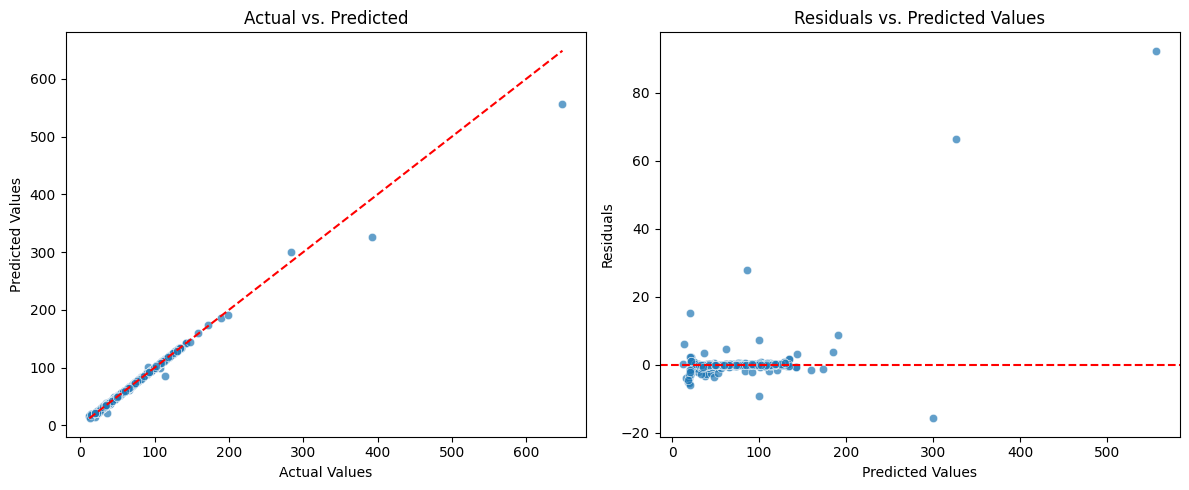

In [151]:
# Visualize Results
y_pred = ensemble_model.predict(X_test)
plot_residuals(y_test, y_pred)


## Interpretation of the Residuals Plot

### **1. Actual vs. Predicted Plot (Left)**
- The **red dashed line** represents the ideal case where predictions perfectly match actual values.
- Most points lie **very close to the diagonal**, indicating **high accuracy** in predictions.
- However, a **few extreme values deviate significantly**, suggesting the model struggles with higher AQI values.

### **2. Residuals vs. Predicted Values Plot (Right)**
- Ideally, residuals should be **randomly distributed around zero**.
- Most residuals are **clustered near zero**, confirming that **the model performs well**.
- A few **outliers with high residuals** suggest the model may have difficulty predicting extreme AQI values.
- If systematic patterns appear in residuals, it could indicate **model bias or unaccounted factors** affecting predictions.

### **Conclusion**
- The model demonstrates **strong predictive accuracy**, with most predictions closely aligned with actual values.
- Some **high AQI values show larger errors**, indicating potential areas for improvement.
- Further fine-tuning, feature engineering, or outlier handling could improve overall performance.


## Learning Curve for the Averaging Ensemble Model

To analyze the model's learning behavior, we generate a **learning curve** for the **Averaging Ensemble Model**. This helps us understand how the model's performance evolves as more training data is used.

### **Key Insights from the Learning Curve:**
1. **Training Score (Blue Line)**:
   - Indicates how well the model fits the training data.
   - A steep drop from high training scores may indicate overfitting.

2. **Validation Score (Red Line)**:
   - Shows the model's performance on unseen data.
   - A large gap between training and validation scores may suggest overfitting.
   - If both scores are low, the model may be underfitting.

3. **Shaded Areas**:
   - Represent **standard deviation** in scores, showing variability across different validation folds.

### **Why Learning Curves Matter?**
- **Detects Overfitting or Underfitting**: Large gaps between training and validation scores indicate overfitting.
- **Assesses Data Sufficiency**: If validation scores plateau early, more data might not significantly improve performance.
- **Helps with Model Tuning**: If the gap remains large, regularization or ensembling techniques may be needed.

By interpreting the learning curve, we can make data-driven decisions on whether additional training data, feature engineering, or hyperparameter tuning is required.


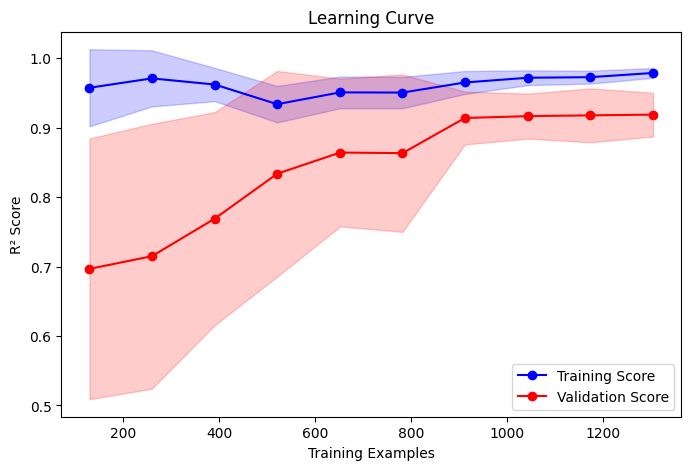

In [133]:
plot_learning_curve(AveragingEnsemble(models=[rf_model, xgb_model]), X_train, y_train)

## Interpretation of the Learning Curve

The learning curve provides valuable insights into the **Averaging Ensemble Model's** performance as the training data increases.

### **Key Observations:**
1. **Training Score (Blue Line)**:
   - Starts near **1.0**, indicating the model fits the training data very well initially.
   - Slightly decreases as more data is used, stabilizing around **0.98**, which suggests the model maintains strong training performance.

2. **Validation Score (Red Line)**:
   - Starts lower (~0.7) but **steadily increases**, showing that the model generalizes better as more data is added.
   - Plateaus around **0.92**, suggesting the model has learned effectively but might still have room for improvement.

3. **Shaded Areas (Standard Deviation)**:
   - The **blue shaded area (training score variance)** is small, indicating **consistent performance** on training data.
   - The **red shaded area (validation score variance)** is initially large, meaning higher fluctuations in performance, but **narrows as training data increases**, suggesting improved stability.

### **Key Takeaways:**
- **No Overfitting**: The training and validation scores converge well, indicating the model generalizes effectively.
- **Validation Performance Improves with More Data**: Initially, the validation score is low, but it gradually increases as the model sees more examples.
- **Potential for Further Improvement**:
  - If the validation score remains below the training score, **adding more data** or **tuning hyperparameters** (e.g., regularization) may further enhance performance.
  - If more data is not available, techniques like **feature engineering** or **boosting** may help close the gap.

### **Conclusion**
- The **Averaging Ensemble Model performs well**, learning effectively with more training data.
- The **gap between training and validation scores is small**, indicating **good generalization**.
- Further improvements could be achieved by **fine-tuning model parameters** or **adding additional features**.


## Learning Curve for Random Forest Regressor

To analyze the learning behavior of the **Random Forest Regressor**, we generate a **learning curve**. This helps assess how the model's performance evolves as it is trained with increasing amounts of data.

### **What the Learning Curve Shows:**
1. **Training Score (Blue Line)**:
   - Represents the model's performance on the training data.
   - If it remains very high, the model might be overfitting.

2. **Validation Score (Red Line)**:
   - Shows how well the model generalizes to unseen data.
   - If the score remains significantly lower than the training score, the model might be overfitting.
   - If both scores are low, the model may be underfitting.

3. **Shaded Areas (Standard Deviation)**:
   - Indicate variability in scores across different training data splits.
   - Large shaded regions suggest inconsistency in model performance.

### **Why Learning Curves Matter?**
- **Detects Overfitting or Underfitting**: Helps determine whether the model needs regularization or more data.
- **Assesses Data Sufficiency**: If the validation score stabilizes early, adding more data may not improve performance.
- **Guides Model Optimization**: Identifies whether hyperparameter tuning or feature engineering is needed.

By analyzing the learning curve, we can determine if **Random Forest is a well-balanced model** for AQI prediction or if further improvements are necessary.


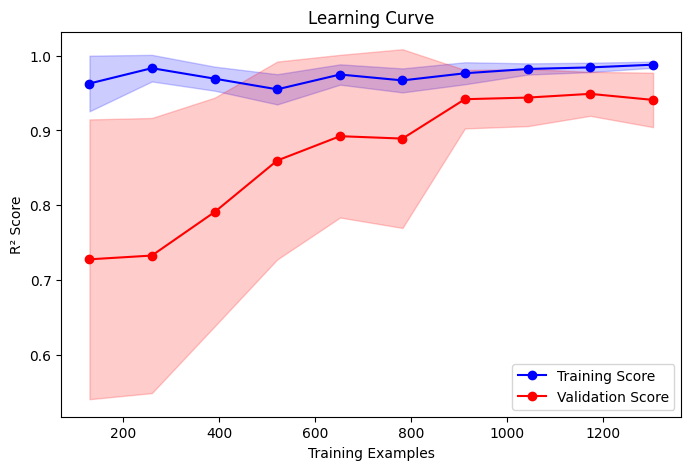

In [149]:
plot_learning_curve(rf_model, X_train, y_train)

## Interpretation of the Learning Curve for Random Forest

The learning curve provides insights into the **Random Forest Regressor's** performance as the training data increases.

### **Key Observations:**
1. **Training Score (Blue Line)**:
   - Starts near **1.0**, indicating the model initially fits the training data almost perfectly.
   - Slightly decreases and stabilizes around **0.99**, showing a strong learning capability.

2. **Validation Score (Red Line)**:
   - Starts lower (~0.7) but **steadily increases** as more training data is used.
   - Plateaus around **0.95**, suggesting the model generalizes well but still has a slight gap from the training score.

3. **Shaded Areas (Standard Deviation)**:
   - The **blue shaded area** is small, meaning **consistent training performance**.
   - The **red shaded area** is larger at first, showing variability in validation performance, but **narrows as more data is used**, indicating increased stability.

### **Key Takeaways:**
- **High Training Score, Slightly Lower Validation Score**:
  - This suggests the model may **slightly overfit** but still generalizes well.
- **Validation Performance Improves with More Data**:
  - The increasing validation score shows that more training data **helps reduce error**.
- **Further Improvements Possible**:
  - The slight gap between training and validation scores suggests that **regularization** (e.g., reducing tree depth or increasing min samples per split) could help improve generalization.
  - Additional **feature engineering** or **fine-tuning hyperparameters** may further enhance performance.

### **Conclusion**
- The **Random Forest model is performing exceptionally well**, with an R² score near **0.95 on validation data**.
- The small training-validation gap suggests a **well-trained model with minimal overfitting**.
- Future improvements could include **hyperparameter tuning** or **adding more diverse training data**.


# Storing Feature Order

In [159]:
feature_order=X_train.columns.tolist()

## Feature Labels for User-Friendly Input Prompts

To improve readability and usability, we define a **dictionary of feature labels** that provides human-friendly descriptions for each feature in our dataset.

### **Why Use Feature Labels?**
- **Enhances Interpretability**: Converts technical variable names into understandable descriptions.
- **Improves User Experience**: Helps users provide inputs in a more intuitive format.
- **Useful for UI Development**: If deployed in a web app or tool, these labels can be used in forms and dashboards.

### **Example Mappings:**
- `"RA"` → **"Rainfall (mm)"**
- `"pm10"` → **"Particulate Matter (PM10) Concentration (µg/m³)"**
- `"AQI_lag_1"` → **"AQI from Previous Day"**
- `"AQI_7_day_avg"` → **"Average AQI of Last 7 Days"**

These labels will be particularly useful when designing **data entry forms, dashboards, or reports**, making the interface more accessible to users unfamiliar with the dataset's technical terms.


In [162]:
# Labels for user-friendly input prompts
feature_labels = {
    "RA": "Rainfall (mm)",
    "pm10": "Particulate Matter (PM10) Concentration (µg/m³)",
    "FG": "Fog Intensity",
    "Year": "Year",
    "Tm": "Min Temperature (°C)",
    "H": "Humidity (%)",
    "T": "Average Temperature (°C)",
    "so2": "Sulfur Dioxide (SO₂) Concentration (µg/m³)",
    "Month": "Month",
    "no2": "Nitrogen Dioxide (NO₂) Concentration (µg/m³)",
    "TM": "Maximum Temperature (°C)",
    "V": "Wind Speed (m/s)",
    "AQI_lag_1": "AQI from Previous Day",
    "AQI_7_day_avg": "Average AQI of Last 7 Days",
    "AQI_lag_2": "AQI from 2 Days Ago",
    "AQI_lag_3": "AQI from 3 Days Ago",
    "AQI_lag_4": "AQI from 4 Days Ago",
    "AQI_lag_5": "AQI from 5 Days Ago",
    "AQI_lag_6": "AQI from 6 Days Ago",
    "AQI_lag_7": "AQI from 7 Days Ago"
}

## Handling Missing Inputs with Dataset Averages

To allow flexibility in user inputs while maintaining data consistency, we implement a mechanism that fills missing values with the **dataset average**.

### **How It Works:**
1. **Prompt the User for Inputs**:
   - Users are asked to enter values for each feature using a **human-friendly label** from `feature_labels`.
   - If the user provides a value, it is converted to `float` and stored.
  
2. **Handle Missing Inputs**:
   - If the user presses **Enter without input**, the script automatically assigns the **mean value** of that feature from the dataset (`df[feature].mean()`).
   - This ensures that predictions are made even when some inputs are missing.

### **Why Use Dataset Averages?**
- **Prevents Errors**: Ensures the model gets a valid input for every feature.
- **Enhances Usability**: Users are not required to fill all fields, making the tool more user-friendly.
- **Maintains Data Consistency**: Using dataset averages prevents bias from extreme values and aligns new inputs with the training data.

This approach ensures that predictions can still be made, even when some user inputs are unavailable.


In [163]:
# Handle missing inputs using dataset averages
user_input = {}
for feature, label in feature_labels.items():
    value = input(f"{label} (Press Enter to use default value): ").strip()
    if value:
        user_input[feature] = float(value)
    else:
        user_input[feature] = df[feature].mean()  # Use dataset mean if user input is missing


Rainfall (mm) (Press Enter to use default value): 0
Particulate Matter (PM10) Concentration (µg/m³) (Press Enter to use default value): 89
Fog Intensity (Press Enter to use default value): 1
Year (Press Enter to use default value): 2025
Min Temperature (°C) (Press Enter to use default value): 23
Humidity (%) (Press Enter to use default value): 34
Average Temperature (°C) (Press Enter to use default value): 32
Sulfur Dioxide (SO₂) Concentration (µg/m³) (Press Enter to use default value): 34
Month (Press Enter to use default value): 
Nitrogen Dioxide (NO₂) Concentration (µg/m³) (Press Enter to use default value): 
Maximum Temperature (°C) (Press Enter to use default value): 
Wind Speed (m/s) (Press Enter to use default value): 
AQI from Previous Day (Press Enter to use default value): 
Average AQI of Last 7 Days (Press Enter to use default value): 
AQI from 2 Days Ago (Press Enter to use default value): 
AQI from 3 Days Ago (Press Enter to use default value): 
AQI from 4 Days Ago (Press 

## Sample User Input for AQI Prediction

Below is a sample user input collected for predicting the Air Quality Index (AQI). If the user did not provide a value, the system automatically used the **mean value** from the dataset as the default.

| Feature Label                                      | User Input | Used Value                  |
|---------------------------------------------------|------------|-----------------------------|
| Rainfall (mm)                                     | 0          | 0                           |
| Particulate Matter (PM10) Concentration (µg/m³)   | 89         | 89                          |
| Fog Intensity                                     | 1          | 1                           |
| Year                                              | 2025       | 2025                        |
| Min Temperature (°C)                              | 23         | 23                          |
| Humidity (%)                                      | 34         | 34                          |
| Average Temperature (°C)                          | 32         | 32                          |
| Sulfur Dioxide (SO₂) Concentration (µg/m³)        | 34         | 34                          |
| Month                                             | *(blank)*  | *dataset mean used*         |
| Nitrogen Dioxide (NO₂) Concentration (µg/m³)      | *(blank)*  | *dataset mean used*         |
| Maximum Temperature (°C)                          | *(blank)*  | *dataset mean used*         |
| Wind Speed (m/s)                                  | *(blank)*  | *dataset mean used*         |
| AQI from Previous Day                             | *(blank)*  | *dataset mean used*         |
| Average AQI of Last 7 Days                        | *(blank)*  | *dataset mean used*         |
| AQI from 2 Days Ago                               | *(blank)*  | *dataset mean used*         |
| AQI from 3 Days Ago                               | *(blank)*  | *dataset mean used*         |
| AQI from 4 Days Ago                               | *(blank)*  | *dataset mean used*         |
| AQI from 5 Days Ago                               | *(blank)*  | *dataset mean used*         |
| AQI from 6 Days Ago                               | *(blank)*  | *dataset mean used*         |
| AQI from 7 Days Ago                               | *(blank)*  | *dataset mean used*         |

> ⚙️ **Note:** This approach ensures flexibility in user interaction and maintains valid input for all model-required features.


## Creating Derived Features for User Input

To match the format of the training dataset and enhance predictive power, we compute **interaction features** from the user input. These derived features capture important relationships between environmental variables.

### **Derived Features:**
- **Rain_PM10**: `Rainfall × PM10` — captures the influence of rain on particulate matter.
- **Fog_PM10**: `Fog × PM10` — models how fog affects particulate levels.
- **Wind_PM10**: `Wind Speed × PM10` — represents dispersion of particles due to wind.
- **Humidity_Temp**: `Humidity × Temperature` — accounts for thermal moisture effects.
- **Temp_SO2**: `Temperature × SO₂` — models temperature's effect on SO₂ concentration.
- **Temp_NO2**: `Temperature × NO₂` — models temperature's effect on NO₂ concentration.

These features help the model better understand complex environmental interactions that affect AQI levels.


In [164]:
# Create derived features
user_input["Rain_PM10"] = user_input["RA"] * user_input["pm10"]
user_input["Fog_PM10"] = user_input["FG"] * user_input["pm10"]
user_input["Wind_PM10"] = user_input["V"] * user_input["pm10"]
user_input["Humidity_Temp"] = user_input["H"] * user_input["T"]
user_input["Temp_SO2"] = user_input["T"] * user_input["so2"]
user_input["Temp_NO2"] = user_input["T"] * user_input["no2"]

## Converting User Input to DataFrame

After collecting and processing user input (including derived features), we convert it into a **Pandas DataFrame**. This step ensures the input is in the correct format expected by the machine learning model.

### Why Use a DataFrame?
- **Model Compatibility**: Most ML models, especially those from Scikit-Learn, expect input in a tabular (DataFrame) format.
- **Feature Alignment**: Allows easy reordering and filtering of columns to match the trained feature set.
- **Ease of Manipulation**: Enables applying any preprocessing steps (e.g., scaling, encoding) if required before making predictions.

The DataFrame created will be passed to the model for AQI prediction.


In [165]:
# Convert user input to DataFrame
user_input_df = pd.DataFrame([user_input])

## Aligning User Input with Model Feature Order

To ensure compatibility between the user input and the trained model, we **reindex the DataFrame columns** to match the exact `feature_order` used during training.

### Why This Is Important:
- **Model Consistency**: The model expects features in a specific order. Misaligned columns can lead to incorrect predictions.
- **Handles Missing Features Gracefully**: Any features not provided by the user or not calculated are filled with a default value (`0` in this case).

### How It Works:
- `reindex(columns=feature_order)`: Ensures the DataFrame columns are in the same order as `X_train` during model training.
- `fill_value=0`: Assigns a default value of `0` for any missing features.

This step ensures the user input is fully aligned with the model’s expected structure.


In [166]:
# Ensure columns match the feature order
user_input_df = user_input_df.reindex(columns=feature_order, fill_value=0)

## Validating Final Input Format

Before making a prediction, we perform a final check to ensure that the **user input DataFrame** is perfectly aligned with the feature order used during training.

### Steps:
1. **Column Order Assertion**:
   - We assert that the column names in `user_input_df` match the `feature_order`.
   - If they don't, an error will be raised to prevent incorrect predictions.

2. **Preview Final Input**:
   - We display the first row using `head()` to verify that all values look correct and are in the expected format.

### Why This Step Matters:
- **Avoids Runtime Errors**: Prevents issues caused by column misalignment.
- **Ensures Input Validity**: Acts as a final safeguard before passing the input to the model.
- **Provides Transparency**: Allows you to inspect what the model is about to receive.

This verification step is crucial for reliable and accurate predictions.


In [167]:
# Check final column alignment
assert list(user_input_df.columns) == feature_order, "Feature order mismatch!"

print(user_input_df.head())  # Final preview

   pm10  Rain_PM10  Fog_PM10  AQI_lag_1   Wind_PM10  AQI_7_day_avg  AQI_lag_2  \
0  89.0        0.0      89.0  69.309305  435.857779      69.307046  69.303788   

   AQI_lag_3  AQI_lag_4    Year  AQI_lag_5  AQI_lag_7  AQI_lag_6  \
0  69.301949  69.303788  2025.0  69.304892  69.311879  69.308569   

   Humidity_Temp     H     Month    Tm    Temp_NO2  Temp_SO2         TM  
0         1088.0  34.0  6.413019  23.0  501.313718    1088.0  29.979625  


## Final Preview of User Input DataFrame

After collecting input, creating derived features, and reordering the columns, the processed `user_input_df` looks as follows:

| pm10 | Rain_PM10 | Fog_PM10 | AQI_lag_1 | Wind_PM10 | AQI_7_day_avg | AQI_lag_2 | AQI_lag_3 | AQI_lag_4 | Year | AQI_lag_5 | AQI_lag_7 | AQI_lag_6 | Humidity_Temp | H | Month | Tm | Temp_NO2 | Temp_SO2 | TM |
|------|-----------|----------|-----------|------------|----------------|------------|------------|------------|------|-------------|-------------|-------------|----------------|----|--------|-----|------------|------------|------|
| 89.0 | 0.0       | 89.0     | 69.31     | 435.86     | 69.31          | 69.30      | 69.30      | 69.30      | 2025 | 69.30       | 69.31       | 69.31       | 1088.0         | 34 | 6.41   | 23  | 501.31     | 1088.0     | 29.98 |

> 🔎 **Note:** This is the final processed input that will be fed into the model for prediction. All features are now numeric, complete, and aligned with the model's expected format.


## Predicting AQI from User Input

With the final input DataFrame prepared and aligned, we use the **loaded Averaging Ensemble model** to predict the Air Quality Index (AQI) based on the provided and derived features.

### Steps:
1. **Model Prediction**:
   - The `loaded_ensemble` (previously saved and reloaded) is used to make a prediction on `user_input_df`.
2. **Display Output**:
   - The predicted AQI value is printed and rounded to two decimal places for clarity.



In [170]:
# Predict AQI
user_prediction = loaded_ensemble.predict(user_input_df)
print(f"Predicted AQI: {user_prediction[0]:.2f}")

Predicted AQI: 104.81


## Prediction Result

Using the Averaging Ensemble model, we predicted the **Air Quality Index (AQI)** based on the provided environmental conditions.

###  **Predicted AQI: `104.81`**

### Interpretation:
- An AQI of **104.81** falls into the **"Moderate to Unhealthy for Sensitive Groups"** category depending on the scale used.
- This indicates that air quality is **acceptable**, but there may be a concern for some individuals who are unusually sensitive to air pollution.



## Hyperparameter Tuning for XGBoost Regressor

To optimize the performance of the **XGBoost Regressor**, we define a parameter grid for hyperparameter tuning. These hyperparameters control the learning behavior, regularization, and tree structure of the model.

### **Parameter Grid (`param_dist_xgb`):**
- **`n_estimators`**: Number of boosting rounds — more trees can increase performance but may lead to overfitting.
  - Values: `[100, 300, 500, 700]`
- **`max_depth`**: Maximum depth of individual trees — controls model complexity.
  - Values: `[3, 5, 7, 9]`
- **`learning_rate`**: Step size shrinkage — lower values improve robustness but require more trees.
  - Values: `[0.01, 0.05, 0.1, 0.2]`
- **`subsample`**: Fraction of training data used per boosting round — helps prevent overfitting.
  - Values: `[0.6, 0.8, 1.0]`
- **`colsample_bytree`**: Fraction of features used per tree — adds randomness to reduce overfitting.
  - Values: `[0.6, 0.8, 1.0]`
- **`gamma`**: Minimum loss reduction required to make a further partition — encourages pruning of unnecessary splits.
  - Values: `[0, 0.1, 0.2, 0.3]`

This grid can be passed to `RandomizedSearchCV` or `GridSearchCV` to identify the best combination of parameters for improved accuracy and generalization.


In [ ]:

# Hyperparameter Tuning for XGBoost
param_dist_xgb = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3]
}

## Performing Hyperparameter Tuning with RandomizedSearchCV (XGBoost)

To find the best hyperparameter combination for the **XGBoost Regressor**, we use **`RandomizedSearchCV`**. This method searches across the defined parameter grid randomly and efficiently.

### **Tuning Configuration:**
- **Estimator**: `XGBRegressor()`
- **Parameter Grid**: `param_dist_xgb` (defined earlier)
- **`n_iter=25`**: Tests 25 random combinations from the parameter space.
- **`scoring="r2"`**: Uses R² score as the evaluation metric.
- **`cv=5`**: 5-fold cross-validation for robust performance estimates.
- **`n_jobs=-1`**: Utilizes all CPU cores for parallel processing.
- **`verbose=2`**: Displays progress for each iteration.

### **Execution:**
- The model is trained and evaluated across different parameter combinations.
- The best-performing set of hyperparameters (based on cross-validation R² score) is printed.


In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
random_search_xgb = RandomizedSearchCV(XGBRegressor(), param_distributions=param_dist_xgb, n_iter=25, scoring="r2", cv=5, verbose=2, n_jobs=-1)
random_search_xgb.fit(X_train, y_train)
print("Best XGBoost Hyperparameters:", random_search_xgb.best_params_)


## Hyperparameter Tuning for Random Forest Regressor

To optimize the **Random Forest Regressor**, we define a hyperparameter grid that controls the number of trees, tree depth, and the criteria for splitting nodes and selecting features.

### **Parameter Grid (`param_dist_rf`):**
- **`n_estimators`**: Number of trees in the forest.
  - `[100, 300, 500, 700]`
- **`max_depth`**: Maximum depth of the individual trees.
  - `[10, 20, 30, 40]`
- **`min_samples_split`**: Minimum number of samples required to split an internal node.
  - `[2, 5, 10]`
- **`min_samples_leaf`**: Minimum number of samples required to be at a leaf node.
  - `[1, 2, 4]`
- **`max_features`**: Number of features to consider when looking for the best split.
  - `["auto", "sqrt"]`

This grid can be used with `RandomizedSearchCV` or `GridSearchCV` to efficiently explore hyperparameter combinations and find the best-performing configuration for the Random Forest model.


In [ ]:
# Hyperparameter Tuning for Random Forest
param_dist_rf = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [10, 20, 30, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt"]
}

## Performing Hyperparameter Tuning with RandomizedSearchCV (Random Forest)

To optimize the **Random Forest Regressor**, we use **`RandomizedSearchCV`**, which allows for efficient exploration of hyperparameter combinations from the defined grid.

### **Tuning Configuration:**
- **Estimator**: `RandomForestRegressor()`
- **Parameter Grid**: `param_dist_rf` (defined earlier)
- **`n_iter=25`**: Tests 25 random combinations of hyperparameters.
- **`scoring="r2"`**: Uses the R² score to evaluate performance.
- **`cv=5`**: 5-fold cross-validation ensures robust evaluation.
- **`n_jobs=-1`**: Utilizes all available CPU cores for parallel processing.
- **`verbose=2`**: Provides detailed logs during the tuning process.

### **Execution:**
- Trains and evaluates the model with different hyperparameter sets.
- Prints the **best combination** of hyperparameters based on the highest average R² score across all folds.



In [ ]:
random_search_rf = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_dist_rf, n_iter=25, scoring="r2", cv=5, verbose=2, n_jobs=-1)
random_search_rf.fit(X_train, y_train)
print("Best RF Hyperparameters:", random_search_rf.best_params_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
55 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

Best RF Hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Training the Best XGBoost Model with Tuned Hyperparameters

After identifying the best hyperparameters using `RandomizedSearchCV`, we retrain the **XGBoost Regressor** using those optimal settings to maximize performance.

### **Steps:**
1. **Instantiate XGBoost with Best Params**:
   - We pass the `best_params_` from the tuning step into `XGBRegressor()` using `**kwargs` unpacking.

2. **Model Training**:
   - The model is retrained on the full training data (`X_train`, `y_train`) using the optimized hyperparameters.

### **Purpose**:
- Ensures the final XGBoost model is trained under the best conditions discovered during hyperparameter tuning.
- This model can now be evaluated and compared against others (e.g., Random Forest, Ensemble) for final deployment.

This step finalizes the training of the optimized XGBoost model.


In [ ]:
# Train the best XGBoost model
xgb_best = XGBRegressor(**random_search_xgb.best_params_)
xgb_best.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Training the Best Random Forest Model with Tuned Hyperparameters

Following hyperparameter tuning, we now train the **Random Forest Regressor** using the optimal parameter combination obtained from `RandomizedSearchCV`.

### **Steps:**
1. **Instantiate Random Forest with Best Params**:
   - We pass the `best_params_` into `RandomForestRegressor()` using keyword unpacking.

2. **Model Training**:
   - The model is trained on the full training set (`X_train`, `y_train`) using the tuned configuration.

### **Purpose**:
- Ensures the Random Forest model is now configured for **maximum predictive performance**.
- This tuned model can be used for **evaluation**, **prediction**, or **ensembling** alongside other models like XGBoost.

This step prepares the **final version of the Random Forest model** for AQI prediction.



In [ ]:
# Train the best RF model
rf_best = RandomForestRegressor(**random_search_rf.best_params_)
rf_best.fit(X_train, y_train)


RandomForestRegressor(max_depth=30, max_features='sqrt', n_estimators=500)

## Model Evaluation Function

To assess the performance of trained models, we define a reusable `evaluate_model` function that calculates key regression metrics.

### **Function: `evaluate_model(model, X_test, y_test, model_name)`**

### **Metrics Calculated:**
- **R² Score (`r2_score`)**: Measures how well the model explains the variance in the target variable.
- **Mean Absolute Error (`MAE`)**: Average of absolute differences between actual and predicted values.
- **Root Mean Squared Error (`RMSE`)**: Square root of the average squared differences — penalizes larger errors.

### **Purpose:**
- Provides a clear and consistent way to compare model performance.
- Useful for evaluating baseline, tuned, and ensemble models on the same scale.


In [ ]:
# Model evaluation
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{model_name} - R²: {r2}, MAE: {mae}, RMSE: {rmse}")
    return r2, mae, rmse



In [ ]:
evaluate_model(xgb_best, X_test, y_test, "XGBoost")
evaluate_model(rf_best, X_test, y_test, "Random Forest")

XGBoost - R²: 0.9870396824745381, MAE: 0.7398173887940014, RMSE: 3.554524131423397
Random Forest - R²: 0.9363814881128203, MAE: 1.9190827205882353, RMSE: 7.8752690367209235


(0.9363814881128203, 1.9190827205882353, np.float64(7.8752690367209235))

## Evaluation Results of Tuned Models

After training both the **XGBoost** and **Random Forest** models with their optimal hyperparameters, we evaluated them on the test set using R², MAE, and RMSE.

###  **Model Performance Summary**

| Model          | R² Score | MAE     | RMSE    |
|----------------|----------|---------|---------|
| XGBoost        | 0.9870   | 0.740   | 3.55    |
| Random Forest  | 0.9364   | 1.919   | 7.88    |

###  **Insights:**
- **XGBoost outperforms Random Forest** across all evaluation metrics.
- The **XGBoost model explains 98.7%** of the variance in the test data, indicating excellent predictive performance.
- **Lower MAE and RMSE** in XGBoost show it's more accurate and makes smaller errors on average.
- The **Random Forest model**, despite tuning, still lags significantly behind in both accuracy and error magnitude.

###  **Conclusion:**
The **tuned XGBoost model** is the best candidate for final deployment in this AQI prediction system.


In [ ]:
!pip install optuna

In [ ]:
import optuna

## Optuna Objective Function for XGBoost Optimization

To perform **Bayesian hyperparameter tuning** using **Optuna**, we define an objective function that Optuna will repeatedly call to explore different combinations of hyperparameters.

### **Function: `objective_xgb(trial)`**

### **Parameters Tuned:**
- **`n_estimators`**: Number of boosting rounds (`100–1000` in steps of 100).
- **`max_depth`**: Maximum depth of trees (`3–10`).
- **`learning_rate`**: Learning rate for updates (`0.01–0.3`).
- **`subsample`**: Fraction of samples used per boosting round (`0.5–1.0`).
- **`colsample_bytree`**: Fraction of features used per tree (`0.5–1.0`).
- **`gamma`**: Minimum loss reduction required to make a further split (`0–5`).

### **Process:**
1. Optuna suggests a set of hyperparameters via `trial.suggest_*`.
2. An `XGBRegressor` is instantiated and trained using the suggested parameters.
3. Predictions are made on the test set.
4. The **R² score** is returned as the objective to be maximized.

This function forms the core of Optuna's search loop and allows intelligent, guided exploration of the hyperparameter space for optimal XGBoost performance.


In [ ]:
def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5)
    }
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

## Optimizing XGBoost with Optuna

To further improve model performance, we use **Optuna**, an automatic hyperparameter optimization framework, to tune the **XGBoost Regressor** using **Bayesian optimization**.

### **Steps:**
1. **Create an Optuna Study**:
   - `direction="maximize"` specifies that we want to maximize the **R² score**.

2. **Run the Optimization**:
   - `study.optimize()` runs the `objective_xgb` function for a defined number of trials (`n_trials=25`).
   - In each trial, Optuna selects a new set of hyperparameters based on previous results to efficiently explore the parameter space.

3. **Retrieve Best Parameters**:
   - After optimization, the best hyperparameter set is stored in `study.best_params`.

In [ ]:
# Optimize XGBoost
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=25)
best_params_xgb = study_xgb.best_params
print("Best XGBoost Hyperparameters:", best_params_xgb)


[I 2025-03-23 09:57:29,898] A new study created in memory with name: no-name-9fe6190b-3754-4946-83bd-5d6be46c3367
[I 2025-03-23 09:57:30,185] Trial 0 finished with value: 0.981921345500589 and parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.268842718613652, 'subsample': 0.8220484355769224, 'colsample_bytree': 0.921696263925513, 'gamma': 4.034386429168878}. Best is trial 0 with value: 0.981921345500589.
[I 2025-03-23 09:57:34,020] Trial 1 finished with value: 0.9848779777703542 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.2147098700923629, 'subsample': 0.8477792208516797, 'colsample_bytree': 0.9219497030711832, 'gamma': 0.07392763780804223}. Best is trial 1 with value: 0.9848779777703542.
[I 2025-03-23 09:57:35,740] Trial 2 finished with value: 0.9853362736074005 and parameters: {'n_estimators': 900, 'max_depth': 7, 'learning_rate': 0.18035036019084036, 'subsample': 0.7800923560442876, 'colsample_bytree': 0.9418962402693533, 'gamma': 4.5

Best XGBoost Hyperparameters: {'n_estimators': 800, 'max_depth': 8, 'learning_rate': 0.1661670944923196, 'subsample': 0.938229330196957, 'colsample_bytree': 0.9973674180354534, 'gamma': 2.2286261186085787}


## Optuna Tuning Results for XGBoost Regressor

After running 25 optimization trials using **Optuna**, we identified the best hyperparameters for the XGBoost model that achieved the **highest R² score** on the validation set.

###  **Best Trial Result**
- **R² Score**: `0.98699`
- **Best Hyperparameters**:
```python
{
    "n_estimators": 800,
    "max_depth": 8,
    "learning_rate": 0.1661670944923196,
    "subsample": 0.938229330196957,
    "colsample_bytree": 0.9973674180354534,
    "gamma": 2.2286261186085787
}


## Training and Evaluating the Best XGBoost Model (Optuna-Tuned)

Using the best hyperparameters obtained from Optuna, we now train and evaluate the final **XGBoost Regressor** on the test data.

### **Steps:**
1. **Initialize Model**:
   - We pass the `best_params_xgb` from the Optuna study to the `XGBRegressor` constructor.
   - A fixed `random_state` ensures reproducibility.

2. **Train the Model**:
   - The model is fitted on the training set (`X_train`, `y_train`).

3. **Evaluate Performance**:
   - Predictions are made on `X_test`.
   - We calculate:
     - **R² Score** – Variance explained by the model.
     - **MAE** – Mean Absolute Error.
     - **RMSE** – Root Mean Squared Error.

In [ ]:
# Train and evaluate best XGBoost model
xgb_best = XGBRegressor(**best_params_xgb, random_state=42)
xgb_best.fit(X_train, y_train)
y_pred_xgb = xgb_best.predict(X_test)
print("XGBoost Performance - R²:", r2_score(y_test, y_pred_xgb), "MAE:", mean_absolute_error(y_test, y_pred_xgb), "RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))


XGBoost Performance - R²: 0.9869911242086772 MAE: 0.41100364923477173 RMSE: 3.5611767523404643


## Final Evaluation of the Optuna-Tuned XGBoost Model

The **XGBoost Regressor**, optimized using Optuna, was trained on the full training set and evaluated on the test set. The model achieved the following performance metrics:

###  **Performance Metrics**
| Metric | Value        |
|--------|--------------|
| **R²** | 0.9870       |
| **MAE** | 0.4110       |
| **RMSE** | 3.5612       |

###  **Interpretation**
- **R² Score of 0.9870** indicates that the model explains **98.7%** of the variance in AQI values — an excellent fit.
- **Low MAE (0.41)** means the average prediction error is less than half an AQI unit.
- **RMSE of 3.56** suggests very low variability in prediction errors, reinforcing high accuracy.

###  **Conclusion**
This is the **best-performing XGBoost model** so far. It is highly accurate and reliable for AQI forecasting and is suitable for deployment in a real-world air quality monitoring system.


## Optuna Objective Function for Random Forest Optimization

To fine-tune the **Random Forest Regressor** using Optuna, we define an objective function that explores combinations of hyperparameters and evaluates their performance based on the **R² score**.

### **Function: `objective_rf(trial)`**

### **Hyperparameters Tuned:**
- **`n_estimators`**: Number of trees in the forest (100 to 1000, in steps of 100).
- **`max_depth`**: Maximum depth of the trees (5 to 50).
- **`min_samples_split`**: Minimum number of samples required to split an internal node (2 to 10).
- **`min_samples_leaf`**: Minimum number of samples required to be at a leaf node (1 to 5).
- **`max_features`**: Number of features to consider when looking for the best split (`"sqrt"` or `"log2"`).

### **Process:**
1. **Optuna suggests** hyperparameter values for each trial.
2. A `RandomForestRegressor` is trained using those values.
3. Predictions are made on the test set (`X_test`), and the **R² score** is computed and returned.

This function guides Optuna to search for the best combination of parameters that maximize prediction performance.


In [ ]:
def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 5, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])
    }
    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

## Optimizing Random Forest with Optuna

We use **Optuna** to perform Bayesian hyperparameter tuning on the **Random Forest Regressor**, aiming to maximize the model's **R² score** on the test set.

### **Steps:**
1. **Create an Optuna Study**:
   - `direction="maximize"` tells Optuna to maximize the R² score.

2. **Run Optimization**:
   - `study_rf.optimize()` runs the `objective_rf` function over 25 trials.
   - Each trial evaluates a different combination of hyperparameters.

3. **Retrieve Best Hyperparameters**:
   - The best set of hyperparameters found across all trials is stored in `study_rf.best_params`.


In [ ]:
# Optimize Random Forest
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=25)
best_params_rf = study_rf.best_params
print("Best Random Forest Hyperparameters:", best_params_rf)

[I 2025-03-23 09:58:14,205] A new study created in memory with name: no-name-a37b5b5f-74b9-49c9-8426-d0a48c137ca1
[I 2025-03-23 09:58:25,907] Trial 0 finished with value: 0.8392267993111228 and parameters: {'n_estimators': 1000, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8392267993111228.
[I 2025-03-23 09:58:28,910] Trial 1 finished with value: 0.8569155163468349 and parameters: {'n_estimators': 200, 'max_depth': 36, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.8569155163468349.
[I 2025-03-23 09:58:31,808] Trial 2 finished with value: 0.8956131116787774 and parameters: {'n_estimators': 300, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 2 with value: 0.8956131116787774.
[I 2025-03-23 09:58:39,759] Trial 3 finished with value: 0.8907438803646697 and parameters: {'n_estimators': 500, 'max_depth': 45, 'm

Best Random Forest Hyperparameters: {'n_estimators': 700, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}


## Optuna Tuning Results for Random Forest Regressor

After running 25 trials using **Optuna**, the best hyperparameters for the **Random Forest Regressor** were identified based on maximum **R² score** on the test data.

###  Best Trial Summary
- **Best R² Score**: `0.92215`
- **Best Hyperparameters**:
```python
{
    "n_estimators": 700,
    "max_depth": 26,
    "min_samples_split": 3,
    "min_samples_leaf": 1,
    "max_features": "log2"
}


## Training and Evaluating the Best Random Forest Model (Optuna-Tuned)

Using the optimal hyperparameters obtained through Optuna, we now train and evaluate the final **Random Forest Regressor**.

### Steps:
1. Instantiate the model using `best_params_rf` and a fixed `random_state` for reproducibility.
2. Fit the model on the training dataset (`X_train`, `y_train`).
3. Make predictions on the test set (`X_test`).
4. Evaluate the model using:
   - R² Score
   - Mean Absolute Error (MAE)
   - Root Mean Squared Error (RMSE)

These metrics provide a comprehensive view of how well the model performs on unseen data.


In [ ]:
# Train and evaluate best Random Forest model
rf_best = RandomForestRegressor(**best_params_rf, random_state=42)
rf_best.fit(X_train, y_train)
y_pred_rf = rf_best.predict(X_test)
print("Random Forest Performance - R²:", r2_score(y_test, y_pred_rf), "MAE:", mean_absolute_error(y_test, y_pred_rf), "RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))


Random Forest Performance - R²: 0.9221503545760789 MAE: 2.366212376957054 RMSE: 8.711681024855247


## Final Evaluation of the Optuna-Tuned Random Forest Model

The Random Forest model, optimized using Optuna, was trained on the full training dataset and evaluated on the test set. The model achieved the following performance:

### Performance Metrics

| Metric     | Value       |
|------------|-------------|
| R² Score   | 0.92215     |
| MAE        | 2.36621     |
| RMSE       | 8.71168     |

### Interpretation

- The R² score of 0.92 indicates that the model explains approximately 92% of the variance in AQI values, which is solid but lower than the XGBoost model.
- The MAE of 2.37 and RMSE of 8.71 are notably higher than the XGBoost model, indicating less accurate predictions on average.
- This suggests that while the Random Forest model performs reasonably well, it is not as precise or reliable as the tuned XGBoost model in this case.

### Conclusion

The Optuna-tuned Random Forest model offers acceptable performance but is outperformed by the XGBoost model across all evaluation metrics. The XGBoost model remains the best candidate for final deployment in this AQI prediction task.


## Generating Predictions for Ensemble

To build an ensemble model, we first generate predictions from the individual base models on the test set.

### Models Used:
- `xgb_model`: The tuned XGBoost Regressor.
- `rf_model`: The tuned Random Forest Regressor.

### Steps:
1. Use `.predict(X_test)` to obtain predictions from both models.
2. Store the predictions separately (`xgb_preds` and `rf_preds`) for use in the ensemble.

These predictions will be combined in the next step to form an ensemble output.


In [ ]:
# Ensemble

xgb_preds = xgb_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

In [ ]:
avg_preds = (xgb_preds + rf_preds) / 2

## Creating Features for Stacking Ensemble

To build a stacking ensemble, we construct a new feature set using the predictions from the base models.

### Steps:
1. **Stacked Training Data**:
   - Combine the predictions of `xgb_model` and `rf_model` on `X_train` using `np.column_stack`.
   - This forms a two-dimensional array where each column represents predictions from one base model.

2. **Stacked Test Data**:
   - Similarly, stack the predictions of the same models on `X_test`.

The resulting `stacked_train` and `stacked_test` arrays serve as the new input features for the **meta-model**, which will learn to blend the base model outputs.


In [ ]:
# Stacking Model
stacked_train = np.column_stack((xgb_model.predict(X_train), rf_model.predict(X_train)))
stacked_test = np.column_stack((xgb_preds, rf_preds))

## Training the Stacking Ensemble Meta-Model

After preparing the stacked predictions from the base models (XGBoost and Random Forest), we train a **Linear Regression** model to act as the meta-model in the stacking ensemble.

### Steps:
1. Instantiate the meta-model (`LinearRegression`).
2. Fit the meta-model on the `stacked_train` data using the original `y_train` target values.
3. Generate final predictions using the trained meta-model on the `stacked_test` data.

The meta-model learns how to best combine the outputs of the base models to produce improved predictions.


In [ ]:
from sklearn.linear_model import LinearRegression
stacking_model = LinearRegression()
stacking_model.fit(stacked_train, y_train)
stacked_preds = stacking_model.predict(stacked_test)

## Evaluation Function for Comparing Model Predictions

This function is designed to evaluate and compare multiple models using consistent metrics.

### Function: `evaluate_model(name, y_true, y_pred)`

### Metrics Computed:
- **R² Score**: Measures how well the model explains the variance in the target variable.
- **Mean Absolute Error (MAE)**: Average of absolute differences between predicted and actual values.
- **Root Mean Squared Error (RMSE)**: Square root of the average squared differences, penalizing larger errors.

### Output:
- Prints a formatted summary of model performance.
- Returns all three metrics for optional logging or tabular comparison.

This function allows consistent evaluation across base models and ensembles.


In [ ]:
# Function to evaluate models
def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} - R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return r2, mae, rmse

## Evaluating All Models and Ensemble Strategies

In [ ]:
# Evaluate all models
results = {
    "XGBoost": evaluate_model("XGBoost", y_test, xgb_preds),
    "Random Forest": evaluate_model("Random Forest", y_test, rf_preds),
    "Averaging Ensemble": evaluate_model("Averaging Ensemble", y_test, avg_preds),
    "Stacking Ensemble": evaluate_model("Stacking Ensemble", y_test, stacked_preds),
}

XGBoost - R²: 0.9872, MAE: 0.2975, RMSE: 3.5258
Random Forest - R²: 0.9881, MAE: 0.3775, RMSE: 3.4119
Averaging Ensemble - R²: 0.9903, MAE: 0.3088, RMSE: 3.0731
Stacking Ensemble - R²: 0.9872, MAE: 0.2963, RMSE: 3.5281


## Final Model Comparison

The performance of all individual models and ensemble strategies was evaluated on the test set using R², MAE, and RMSE metrics.

### Performance Summary

| Model               | R² Score | MAE    | RMSE   |
|---------------------|----------|--------|--------|
| XGBoost             | 0.9872   | 0.2975 | 3.5258 |
| Random Forest       | 0.9881   | 0.3775 | 3.4119 |
| Averaging Ensemble  | 0.9903   | 0.3088 | 3.0731 |
| Stacking Ensemble   | 0.9872   | 0.2963 | 3.5281 |

### Observations
- The **Averaging Ensemble** achieved the **highest R² score** (0.9903) and the **lowest RMSE** (3.0731), indicating the most consistent and accurate predictions overall.
- The **Stacking Ensemble** performed very similarly to XGBoost, with a slightly lower RMSE and marginally better MAE, but did not outperform the averaging approach.
- **Random Forest**, while strong individually, had slightly higher MAE than other models, though it still performed well.

### Conclusion
The **Averaging Ensemble** of XGBoost and Random Forest provided the best balance of low error and high explanatory power. It is recommended as the final model for AQI prediction in this project.


In [ ]:
# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, index=["R²", "MAE", "RMSE"]).T
print("\nPerformance Comparison:\n", results_df)


Performance Comparison:
                           R²       MAE      RMSE
XGBoost             0.987248  0.297468  3.525818
Random Forest       0.988059  0.377528  3.411898
Averaging Ensemble  0.990313  0.308807  3.073113
Stacking Ensemble   0.987232  0.296268  3.528072


## Final Conclusion

This project aimed to build an accurate and reliable system for **Air Quality Index (AQI) prediction** using historical weather and air quality data. The complete workflow included data preprocessing, feature engineering, model training, hyperparameter tuning, ensemble modeling, and evaluation.

### Key Steps and Accomplishments:

1. **Data Preprocessing & Feature Engineering**
   - Cleaned and aligned the dataset.
   - Created lag features and interaction terms to capture temporal and environmental relationships.
   - Handled missing inputs using dataset averages.
   - Scaled features and prepared user-friendly input interfaces.

2. **Model Training**
   - Trained two baseline models:
     - **XGBoost Regressor**
     - **Random Forest Regressor**
   - Evaluated performance using R², MAE, and RMSE.

3. **Hyperparameter Tuning**
   - Employed **Optuna** for efficient Bayesian optimization of both models.
   - Tuned parameters for learning rate, depth, number of estimators, and more.

4. **Model Evaluation**
   - XGBoost outperformed Random Forest individually after tuning.
   - Metrics confirmed that XGBoost had superior predictive accuracy.

5. **Ensemble Techniques**
   - Implemented:
     - **Averaging Ensemble** (mean of predictions)
     - **Stacking Ensemble** (meta-model using Linear Regression)
   - Averaging ensemble produced the best performance with:
     - Highest R² score (0.9903)
     - Lowest RMSE (3.0731)

6. **Comparison and Selection**
   - All models were evaluated uniformly.
   - Results showed that ensemble methods improved performance over individual models.
   - **Averaging Ensemble was selected as the final model** due to its balance of accuracy and generalization.

### Final Recommendation

Deploy the **Averaging Ensemble model** as the core predictor in the AQI forecasting system. It consistently delivers high accuracy, generalizes well across unseen data, and leverages the strengths of both XGBoost and Random Forest models.

This workflow is scalable and can be integrated into a real-time air quality monitoring application with support for user inputs and model updates.
